In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms

In [2]:
import random

def create_rare_token(tokenizer, num_tokens=1, token_range=(5000, 10000), max_length=3):
    """
    Generates a rare identifier by sampling tokens from the tokenizer's vocabulary.
    
    Args:
        tokenizer: Hugging Face tokenizer (e.g. T5Tokenizer).
        num_tokens: Number of tokens to sample (concatenated in order).
        token_range: Tuple indicating the range of token IDs to consider.
        max_length: Maximum length (in characters) for each decoded token.
    
    Returns:
        A string identifier that is the concatenation of sampled rare tokens.
    """
    candidate_tokens = []
    
    # Iterate through the specified token ID range.
    for token_id in range(token_range[0], token_range[1]):
        token_str = tokenizer.decode([token_id]).strip()
        # Check that the token is non-empty, doesn't contain spaces, and is short.
        if token_str and (" " not in token_str) and (len(token_str) <= max_length):
            candidate_tokens.append(token_str)
    
    if not candidate_tokens:
        raise ValueError("No suitable rare tokens found in the given range.")
    
    # Randomly sample the requested number of tokens and concatenate them.
    selected_tokens = random.choices(candidate_tokens, k=num_tokens)
    rare_identifier = "".join(selected_tokens)
    return rare_identifier

In [3]:
# -------------------------------
# 2. Define Tokenizer, Text Encoder and Image Transforms
# -------------------------------
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")

In [4]:
# -------------------------------
# 1. Load & Prepare Dataset with DreamBooth Prompts
# -------------------------------
# Set DreamBooth prompt parameters.
use_dreambooth_prompts = True
subject_identifier = create_rare_token(tokenizer)
subject_class = "dog"             # The coarse class (e.g., "dog")
subject_prompt = f"a {subject_identifier} {subject_class}"
class_prompt = f"a {subject_class}"

In [5]:
subject_prompt

'a seo dog'

In [6]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
from torch.utils.data import Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, subject_prompt, class_prompt, tokenizer, transforms, use_dreambooth_prompts=True):
        self.image_dir = image_dir
        self.subject_prompt = subject_prompt
        self.class_prompt = class_prompt
        self.tokenizer = tokenizer
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms
        self.use_dreambooth_prompts = use_dreambooth_prompts

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        prompt = self.subject_prompt if self.use_dreambooth_prompts else self.class_prompt
        encoding = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=self.tokenizer.model_max_length, return_tensors='pt')
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return image, input_ids, attention_mask

In [8]:
# Usage example
image_dir = '/home/i_golov/Diffusion/GAI_course_project/data/paper_dataset/dog'
subject_prompt = "a sks dog"
class_prompt = "a dog"
use_dreambooth_prompts = True

dataset = CustomDataset(image_dir, subject_prompt, class_prompt, tokenizer, train_transforms,)

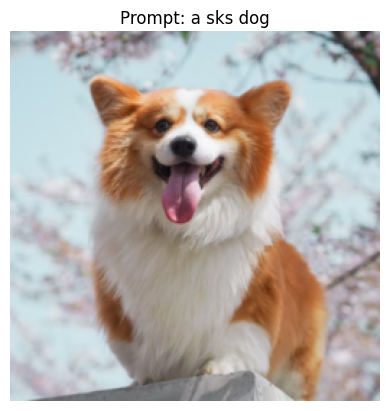

In [9]:
import matplotlib.pyplot as plt
# Function to visualize an image
def visualize_image(dataset, idx):
    image, input_ids, attention_mask = dataset[idx]
    image = image.permute(1, 2, 0)  # Change the order of dimensions for visualization
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize the image
    image = image.numpy()
    
    plt.imshow(image)
    plt.title(f"Prompt: {dataset.subject_prompt if dataset.use_dreambooth_prompts else dataset.class_prompt}")
    plt.axis('off')
    plt.show()

# Visualize the first image in the dataset
visualize_image(dataset, 0)

In [10]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example[1] for example in examples])
    attention_mask = torch.stack([example[2] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [11]:
train_batch_size = 5
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
)

In [12]:
# -------------------------------
# 3. Load Pretrained Diffusion Components
# -------------------------------
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler

In [13]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
revision = None
variant = None

In [14]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

In [15]:
# Freeze VAE, text encoder and (base) unet parameters for memory and stability.
# mixed_precision = "fp16"
mixed_precision = None
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [16]:
import torch
import subprocess

def get_free_gpu():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
    )
    free_memory = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return free_memory.index(max(free_memory))

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    free_gpu = get_free_gpu()
    device = torch.device(f"cuda:{free_gpu}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_dtype = torch.float16 if mixed_precision == "fp16" else torch.float32

unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [17]:
# # -------------------------------
# # 4. Set Up LoRA Adapter (Optional)
# # -------------------------------
# from peft import LoraConfig
# from diffusers.training_utils import cast_training_params

# unet_lora_config = LoraConfig(
#     r=60,
#     lora_alpha=16,
#     init_lora_weights="gaussian",
#     target_modules=["to_k", "to_q", "to_v", "to_out.0"],
# )

# unet.add_adapter(unet_lora_config)
# if mixed_precision == "fp16":
#     cast_training_params(unet, dtype=torch.float32)

In [18]:
# -------------------------------
# 5. Set Up Prior Preservation Mechanism
# -------------------------------
use_prior_preservation = True
prior_loss_weight = 1.0  # lambda in the paper

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating prior preservation latents...
Image №0


  0%|          | 0/50 [00:00<?, ?it/s]

Image №1


  0%|          | 0/50 [00:00<?, ?it/s]

Image №2


  0%|          | 0/50 [00:00<?, ?it/s]

Image №3


  0%|          | 0/50 [00:00<?, ?it/s]

Image №4


  0%|          | 0/50 [00:00<?, ?it/s]

Image №5


  0%|          | 0/50 [00:00<?, ?it/s]

Image №6


  0%|          | 0/50 [00:00<?, ?it/s]

Image №7


  0%|          | 0/50 [00:00<?, ?it/s]

Image №8


  0%|          | 0/50 [00:00<?, ?it/s]

Image №9


  0%|          | 0/50 [00:00<?, ?it/s]

Image №10


  0%|          | 0/50 [00:00<?, ?it/s]

Image №11


  0%|          | 0/50 [00:00<?, ?it/s]

Image №12


  0%|          | 0/50 [00:00<?, ?it/s]

Image №13


  0%|          | 0/50 [00:00<?, ?it/s]

Image №14


  0%|          | 0/50 [00:00<?, ?it/s]

Image №15


  0%|          | 0/50 [00:00<?, ?it/s]

Image №16


  0%|          | 0/50 [00:00<?, ?it/s]

Image №17


  0%|          | 0/50 [00:00<?, ?it/s]

Image №18


  0%|          | 0/50 [00:00<?, ?it/s]

Image №19


  0%|          | 0/50 [00:00<?, ?it/s]

Image №20


  0%|          | 0/50 [00:00<?, ?it/s]

Image №21


  0%|          | 0/50 [00:00<?, ?it/s]

Image №22


  0%|          | 0/50 [00:00<?, ?it/s]

Image №23


  0%|          | 0/50 [00:00<?, ?it/s]

Image №24


  0%|          | 0/50 [00:00<?, ?it/s]

Image №25


  0%|          | 0/50 [00:00<?, ?it/s]

Image №26


  0%|          | 0/50 [00:00<?, ?it/s]

Image №27


  0%|          | 0/50 [00:00<?, ?it/s]

Image №28


  0%|          | 0/50 [00:00<?, ?it/s]

Image №29


  0%|          | 0/50 [00:00<?, ?it/s]

Image №30


  0%|          | 0/50 [00:00<?, ?it/s]

Image №31


  0%|          | 0/50 [00:00<?, ?it/s]

Image №32


  0%|          | 0/50 [00:00<?, ?it/s]

Image №33


  0%|          | 0/50 [00:00<?, ?it/s]

Image №34


  0%|          | 0/50 [00:00<?, ?it/s]

Image №35


  0%|          | 0/50 [00:00<?, ?it/s]

Image №36


  0%|          | 0/50 [00:00<?, ?it/s]

Image №37


  0%|          | 0/50 [00:00<?, ?it/s]

Image №38


  0%|          | 0/50 [00:00<?, ?it/s]

Image №39


  0%|          | 0/50 [00:00<?, ?it/s]

Image №40


  0%|          | 0/50 [00:00<?, ?it/s]

Image №41


  0%|          | 0/50 [00:00<?, ?it/s]

Image №42


  0%|          | 0/50 [00:00<?, ?it/s]

Image №43


  0%|          | 0/50 [00:00<?, ?it/s]

Image №44


  0%|          | 0/50 [00:00<?, ?it/s]

Image №45


  0%|          | 0/50 [00:00<?, ?it/s]

Image №46


  0%|          | 0/50 [00:00<?, ?it/s]

Image №47


  0%|          | 0/50 [00:00<?, ?it/s]

Image №48


  0%|          | 0/50 [00:00<?, ?it/s]

Image №49


  0%|          | 0/50 [00:00<?, ?it/s]

Image №50


  0%|          | 0/50 [00:00<?, ?it/s]

Image №51


  0%|          | 0/50 [00:00<?, ?it/s]

Image №52


  0%|          | 0/50 [00:00<?, ?it/s]

Image №53


  0%|          | 0/50 [00:00<?, ?it/s]

Image №54


  0%|          | 0/50 [00:00<?, ?it/s]

Image №55


  0%|          | 0/50 [00:00<?, ?it/s]

Image №56


  0%|          | 0/50 [00:00<?, ?it/s]

Image №57


  0%|          | 0/50 [00:00<?, ?it/s]

Image №58


  0%|          | 0/50 [00:00<?, ?it/s]

Image №59


  0%|          | 0/50 [00:00<?, ?it/s]

Image №60


  0%|          | 0/50 [00:00<?, ?it/s]

Image №61


  0%|          | 0/50 [00:00<?, ?it/s]

Image №62


  0%|          | 0/50 [00:00<?, ?it/s]

Image №63


  0%|          | 0/50 [00:00<?, ?it/s]

Image №64


  0%|          | 0/50 [00:00<?, ?it/s]

Image №65


  0%|          | 0/50 [00:00<?, ?it/s]

Image №66


  0%|          | 0/50 [00:00<?, ?it/s]

Image №67


  0%|          | 0/50 [00:00<?, ?it/s]

Image №68


  0%|          | 0/50 [00:00<?, ?it/s]

Image №69


  0%|          | 0/50 [00:00<?, ?it/s]

Image №70


  0%|          | 0/50 [00:00<?, ?it/s]

Image №71


  0%|          | 0/50 [00:00<?, ?it/s]

Image №72


  0%|          | 0/50 [00:00<?, ?it/s]

Image №73


  0%|          | 0/50 [00:00<?, ?it/s]

Image №74


  0%|          | 0/50 [00:00<?, ?it/s]

Image №75


  0%|          | 0/50 [00:00<?, ?it/s]

Image №76


  0%|          | 0/50 [00:00<?, ?it/s]

Image №77


  0%|          | 0/50 [00:00<?, ?it/s]

Image №78


  0%|          | 0/50 [00:00<?, ?it/s]

Image №79


  0%|          | 0/50 [00:00<?, ?it/s]

Image №80


  0%|          | 0/50 [00:00<?, ?it/s]

Image №81


  0%|          | 0/50 [00:00<?, ?it/s]

Image №82


  0%|          | 0/50 [00:00<?, ?it/s]

Image №83


  0%|          | 0/50 [00:00<?, ?it/s]

Image №84


  0%|          | 0/50 [00:00<?, ?it/s]

Image №85


  0%|          | 0/50 [00:00<?, ?it/s]

Image №86


  0%|          | 0/50 [00:00<?, ?it/s]

Image №87


  0%|          | 0/50 [00:00<?, ?it/s]

Image №88


  0%|          | 0/50 [00:00<?, ?it/s]

Image №89


  0%|          | 0/50 [00:00<?, ?it/s]

Image №90


  0%|          | 0/50 [00:00<?, ?it/s]

Image №91


  0%|          | 0/50 [00:00<?, ?it/s]

Image №92


  0%|          | 0/50 [00:00<?, ?it/s]

Image №93


  0%|          | 0/50 [00:00<?, ?it/s]

Image №94


  0%|          | 0/50 [00:00<?, ?it/s]

Image №95


  0%|          | 0/50 [00:00<?, ?it/s]

Image №96


  0%|          | 0/50 [00:00<?, ?it/s]

Image №97


  0%|          | 0/50 [00:00<?, ?it/s]

Image №98


  0%|          | 0/50 [00:00<?, ?it/s]

Image №99


  0%|          | 0/50 [00:00<?, ?it/s]

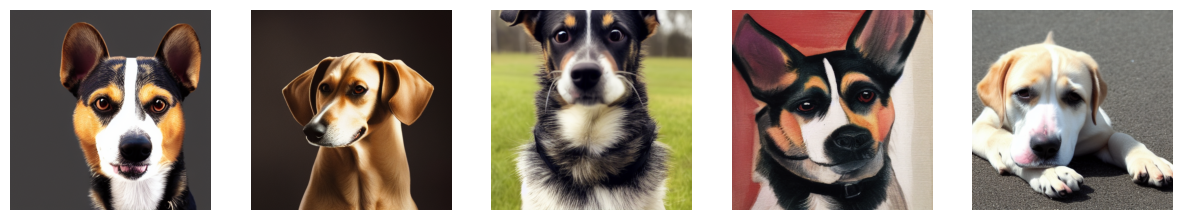

In [20]:
import matplotlib.pyplot as plt

if use_prior_preservation:
    # Create a frozen copy of the original UNet for generating prior samples.
    unet_pretrained = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, 
                                                           subfolder="unet", revision=revision, variant=variant)
    unet_pretrained.to(device, dtype=weight_dtype)
    unet_pretrained.eval()
    
    # Build a separate pipeline using the frozen UNet.
    pipeline_pretrained = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet_pretrained,
        scheduler=noise_scheduler,
        safety_checker=None,
        feature_extractor=None,
    ).to(device)
    
    # Pre-generate a small set of prior samples.
    num_prior_images = 100  # For demo; in practice, many more samples are used.
    prior_latents_list = []
    generated_images = []
    print("Generating prior preservation latents...")
    
    for i in range(num_prior_images):
        print(f"Image №{i}")
        with torch.autocast("cuda"):
            output = pipeline_pretrained(class_prompt, num_inference_steps=50, guidance_scale=7.5)
        gen_image = output.images[0].convert("RGB")
        
        if i < 5:
            generated_images.append(gen_image)
        
        # Convert generated image to tensor.
        gen_image_tensor = train_transforms(gen_image).unsqueeze(0).to(device, dtype=weight_dtype)
        with torch.no_grad():
            latent = vae.encode(gen_image_tensor).latent_dist.sample() * vae.config.scaling_factor
        prior_latents_list.append(latent)
    
    # Prepare prior prompt embeddings (to be reused each iteration)
    prior_inputs = tokenizer(class_prompt, return_tensors="pt", max_length=tokenizer.model_max_length,
                             padding="max_length", truncation=True)
    prior_input_ids = prior_inputs["input_ids"].to(device)
    prior_attention_mask = prior_inputs["attention_mask"].to(device)
    with torch.no_grad():
        prior_embeddings = text_encoder(input_ids=prior_input_ids, attention_mask=prior_attention_mask).last_hidden_state

    # Visualize the first five generated images
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx, img in enumerate(generated_images):
        axes[idx].imshow(img)
        axes[idx].axis('off')
    plt.show()

In [21]:
# -------------------------------
# 6. Set Up Training Hyperparameters & Optimizer
# -------------------------------
num_train_epochs = 1000
learning_rate = 1e-6

optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=learning_rate,
    weight_decay=1e-2,
    eps=1e-08,
)

In [22]:
# Use total steps based on dataset size (using custom_dataset length)
num_training_steps = num_train_epochs * len(dataset) // train_batch_size
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

In [23]:
from torch.utils.data import DataLoader, TensorDataset

# Create a DataLoader for prior latents
prior_latents_tensor = torch.cat(prior_latents_list, dim=0)
prior_dataset = TensorDataset(prior_latents_tensor)
prior_dataloader = DataLoader(prior_dataset, batch_size=train_dataloader.batch_size, shuffle=True)

# Training Loop with Dual (Subject + Prior) Losses
for epoch in tqdm(range(num_train_epochs), desc="Epochs"):
    unet.train()
    epoch_losses = []

    prior_iter = iter(prior_dataloader)

    for index, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        # Move subject batch to device.
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype, device=device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Convert subject images to latent space.
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        latents.requires_grad_(True)  # Ensure latents require gradients

        # Sample noise and timesteps for subject images.
        noise = torch.randn_like(latents, device=device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                  (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from subject prompts.
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict noise residual for subject branch.
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings,
                          encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss_subject = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # ----- Prior Preservation Loss -----
        if use_prior_preservation:
            try:
                prior_batch = next(prior_iter)[0].to(device)
            except StopIteration:
                prior_iter = iter(prior_dataloader)
                prior_batch = next(prior_iter)[0].to(device)

            prior_batch.requires_grad_(True)  # Ensure prior_batch requires gradients

            # For the prior branch, sample noise and timesteps.
            noise_prior = torch.randn_like(prior_batch, device=device)
            t_prior = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                      (prior_batch.shape[0],), device=device).long()
            noisy_prior_latents = noise_scheduler.add_noise(prior_batch, noise_prior, t_prior)

            # Expand prior embeddings to match batch size.
            prior_embeddings_expanded = prior_embeddings.expand(noisy_prior_latents.shape[0], -1, -1)
            prior_attention_mask_expanded = prior_attention_mask.expand(noisy_prior_latents.shape[0], -1)

            # Predict noise residual for prior branch.
            model_pred_prior = unet(noisy_prior_latents, t_prior, encoder_hidden_states=prior_embeddings_expanded,
                                    encoder_attention_mask=prior_attention_mask_expanded, return_dict=False)[0]
            loss_prior = F.mse_loss(model_pred_prior.float(), noise_prior.float(), reduction="mean")
        else:
            loss_prior = 0.0

        # Total loss is the sum of subject loss and weighted prior loss.
        loss = loss_subject + prior_loss_weight * loss_prior

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step() 

        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_train_epochs}, Loss: {avg_loss:.4f}")

Epochs:   0%|          | 1/1000 [00:00<05:15,  3.17it/s]

Epoch 1/1000, Loss: 0.4236


Epochs:  10%|█         | 101/1000 [00:26<04:07,  3.64it/s]

Epoch 101/1000, Loss: 0.5013


Epochs:  20%|██        | 201/1000 [00:53<03:33,  3.75it/s]

Epoch 201/1000, Loss: 0.7306


Epochs:  30%|███       | 301/1000 [01:20<03:05,  3.76it/s]

Epoch 301/1000, Loss: 0.5875


Epochs:  40%|████      | 401/1000 [01:47<02:40,  3.73it/s]

Epoch 401/1000, Loss: 0.4008


Epochs:  50%|█████     | 501/1000 [02:14<02:12,  3.76it/s]

Epoch 501/1000, Loss: 0.5749


Epochs:  60%|██████    | 601/1000 [02:41<01:46,  3.75it/s]

Epoch 601/1000, Loss: 0.4718


Epochs:  70%|███████   | 701/1000 [03:07<01:18,  3.79it/s]

Epoch 701/1000, Loss: 0.4562


Epochs:  80%|████████  | 801/1000 [03:34<00:53,  3.74it/s]

Epoch 801/1000, Loss: 0.2729


Epochs:  90%|█████████ | 901/1000 [04:01<00:26,  3.74it/s]

Epoch 901/1000, Loss: 0.6695


Epochs: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/100 [00:00<?, ?it/s]

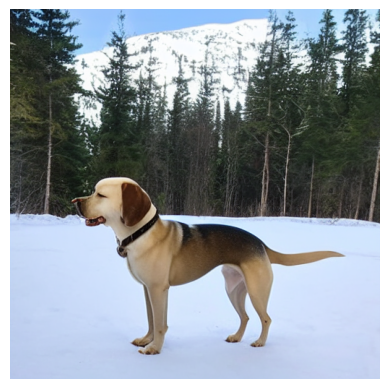

In [24]:
# -------------------------------
# 8. Inference: Generate Images using the Fine-Tuned Model
# -------------------------------
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

# Use a prompt with the unique subject identifier to generate subject images.
prompt = subject_prompt + " in a beautiful landscape"
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"generated_image_{idx}.png")


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/100 [00:00<?, ?it/s]

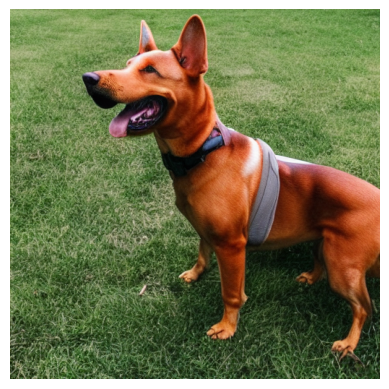

In [27]:
# -------------------------------
# 8. Inference: Generate Images using the Fine-Tuned Model
# -------------------------------
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

# Use a prompt with the unique subject identifier to generate subject images.
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"generated_image_{idx}.png")
